In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes
from amfe.units import convert



msh_file = r'meshes\one_forth_disk_hexa_3D_v1.inp'
m = amfe.Mesh()
m.import_inp(msh_file,1000)


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

*************************************************************

Loading Abaqus-mesh from meshes\one_forth_disk_hexa_3D_v1.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh meshes\one_forth_disk_hexa_3D_v1.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


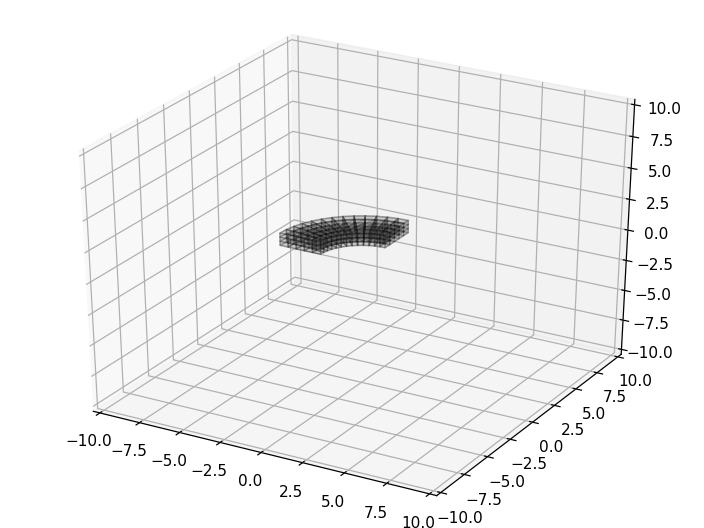

In [2]:
#amfe.plot3Dmesh(m,boundaries=False)
pltmesh = amfe.Plot3DMesh(m,alpha=0.2)
pltmesh.show(plot_nodes=False)
vlim=[-10,10]
pltmesh.set_equal_axis_lim(vlim)


In [3]:
print(m.get_elem_types())
print(m.get_phys_group_types())

{'Quad4', 'Hexa8'}
{'PART_1_1_SOLID_ELSET', 'DIRICHLET_ELSET', 'LEFT_ELSET', 'RIGHT_ELSET', 'NEUMANN_ELSET', 'PART_1_1_ELSET'}


In [4]:
# selection some submeshs to apply B.C.
dirsub = m.get_submesh('phys_group', 'DIRICHLET_ELSET')
cyclic_left = m.get_submesh('phys_group', 'LEFT_ELSET')
cyclic_right = m.get_submesh('phys_group', 'RIGHT_ELSET')
domain = m.set_domain('phys_group','PART_1_1_SOLID_ELSET')
domain.split_in_partitions('phys_group')

{'PART_1_1_SOLID_ELSET': <amfe.mesh.SubMesh at 0x2269b6d56d8>}

In [5]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=False)
my_comp.set_domain('PART_1_1_SOLID_ELSET',my_material)
id_matrix = my_comp.assembly_class.id_matrix

# get dofs
all_dofs = get_dofs(id_matrix)
dir_dofs = amfe.get_dofs(dirsub, direction ='xyz', id_matrix=id_matrix)

# defining sector angle
# set node diamenter
node_diam = 0
theta = np.pi/2.0 #

# creating node pairs
contact = amfe.Cyclic_Contact(cyclic_left,cyclic_right,sector_angle=theta,unit='rad',tol_radius = 1e-3)


# modifying order of nodes to have the correct node pairs for cyclic symmetry
cyclic_left.global_node_list = contact.slaves_nodes
cyclic_right.global_node_list = contact.master_nodes


superset = OrderedSet(dir_dofs)
left_dofs = OrderedSet(amfe.get_dofs(cyclic_left, direction ='xyz', id_matrix=id_matrix)) - superset
right_dofs = OrderedSet(amfe.get_dofs(cyclic_right, direction ='xyz', id_matrix=id_matrix)) - superset

boundary_dofs = superset | left_dofs | right_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
left_dofs = list(left_dofs)
right_dofs = list(right_dofs)

dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['r'] = left_dofs 
dof_dict['l'] = right_dofs
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)

K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()
#plt.matshow(K.todense())

M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 195 elements and 1008 dofs.
Time taken for preallocation: 0.01 seconds.


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [6]:
%%time
# building cyclic matrices
beta = node_diam*theta
ej_beta_plus = np.exp(1J*beta)
M_beta = apply_cyclic_symmetry(M_block,'r','l','i',beta,theta=theta,dimension=3) 
K_beta = apply_cyclic_symmetry(K_block,'r','l','i',beta,theta=theta,dimension=3) 

n_modes = 10
eigval, V = compute_modes(K_beta,M_beta,num_of_modes=n_modes)
#eigval, V = sparse.linalg.eigsh(K_beta, k=n_modes, M=M_beta,which='SM')

Wall time: 767 ms


<IPython.core.display.Javascript object>


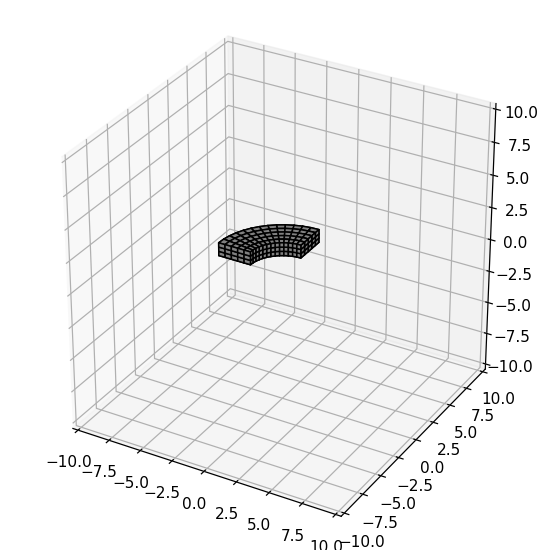

interactive(children=(FloatSlider(value=0.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [7]:
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact


displacement = assemble_cyclic_modes(s,V,node_id=node_diam,theta=theta,compute_left=True,dimension=3)
displacement_list = list(displacement.real.T)
fig = plt.figure(figsize=(5,5))
ax1 = a3.Axes3D(fig) 

#amfe.plot3Dmesh(m,boundaries=False)
pltmesh = amfe.Plot3DMesh(m, displacement_list = displacement_list, ax = ax1, alpha=1.0)
vlim=np.array([-10,10])
pltmesh.set_equal_axis_lim(vlim)

@interact(factor=(-1,1,0.1),u_id=(0,10,1))
def plot(factor=0,u_id=1):
    pltmesh.show(factor=500*factor,plot_nodes=False,displacement_id=u_id, collections=[])
    

In [8]:
n_sector = int((2.0*np.pi)/theta)
sectors_list = []
collections = []
for i in range(n_sector):
    my_comp_i = set_cyclic_modes_to_component(my_comp,s,V,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=3)    
    displacement_i = my_comp_i.u_output
    m_i = my_comp_i.mesh_class
    pltmesh_i = amfe.Plot3DMesh(m_i , scale=1, displacement_list = displacement_i, alpha=1)
    sectors_list.append(pltmesh_i) 
    
    

<IPython.core.display.Javascript object>


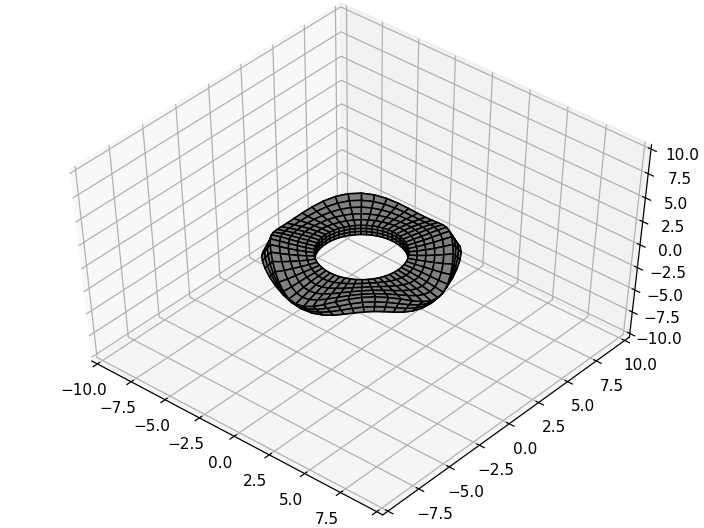

interactive(children=(FloatSlider(value=0.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [9]:
mode_id=1

fig4 = plt.figure()
ax4 = a3.Axes3D(fig4) 
bc = np.array([-10,10])
ax4.set_xlim(bc)
ax4.set_ylim(bc)
ax4.set_zlim(bc)

@interact(factor=(-1,1,0.1),mode_id=(0,n_modes,1))
def plot_3d_cyclic_shape(factor=0,mode_id=1):
    n_sector = int((2.0*np.pi)/theta)
    collections = []
    for n_sector in range(n_sector):
        pltmesh_i = sectors_list[n_sector]
        pltmesh_i.show(factor=500*factor,plot_nodes=False,displacement_id=mode_id,collections=collections,ax=ax4)
    
    patch = pltmesh_i.ax.collections


In [23]:
type(my_comp.mesh_class.elements_dict.iloc[0])

pandas.core.series.Series

In [22]:
my_comp.mesh_class.elements_dict

,0,1,2,3,4,5,6,7
0,0,273,268,228,143,278,253,252
1,0,228,268,273,1,240,269,277
2,1,240,269,277,144,215,214,213
3,0,24,272,273,143,131,279,278
4,0,273,272,24,1,277,276,25
5,1,277,276,25,144,213,212,156
6,24,48,271,272,131,119,280,279
7,24,272,271,48,25,276,275,49
8,25,276,275,49,156,212,211,168
9,48,72,270,271,119,107,281,280


In [25]:
my_comp.mesh_class.elements_dict

,0,1,2,3,4,5,6,7
0,0,273,268,228,143,278,253,252
1,0,228,268,273,1,240,269,277
2,1,240,269,277,144,215,214,213
3,0,24,272,273,143,131,279,278
4,0,273,272,24,1,277,276,25
5,1,277,276,25,144,213,212,156
6,24,48,271,272,131,119,280,279
7,24,272,271,48,25,276,275,49
8,25,276,275,49,156,212,211,168
9,48,72,270,271,119,107,281,280


In [26]:
my_comp.mesh_class.no_of_dofs_per_node

3